In [1]:
from fastai import *
from fastai.vision.all import *

In [2]:
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['figure.dpi'] = 150

In [3]:
path = Path('data/pic/src/640/train/base')

In [4]:
path.ls()

(#2) [Path('data/pic/src/640/train/base/incorrect'),Path('data/pic/src/640/train/base/correct')]

In [5]:
def get_loaders(size, trans_mult = 1., bs = 64):
    dBlock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       splitter = RandomSplitter(seed = 42),
                       get_y = parent_label,
                       item_tfms = Resize((640,int(640 * 1.6))),
                       batch_tfms = aug_transforms(size = (size,int(size * 1.6)),
                                                   max_rotate = 15.,
                                                   min_zoom = 0.95,
                                                   max_zoom = 1.05,
                                                   p_affine = 0.8,
                                                   p_lighting = 0.8,
                                                   max_lighting = 0.3,
                                                   max_warp = 0.3,
                                                   mult = trans_mult
                                                   )
                     )
    
    return dBlock.dataloaders(path, bs = bs)

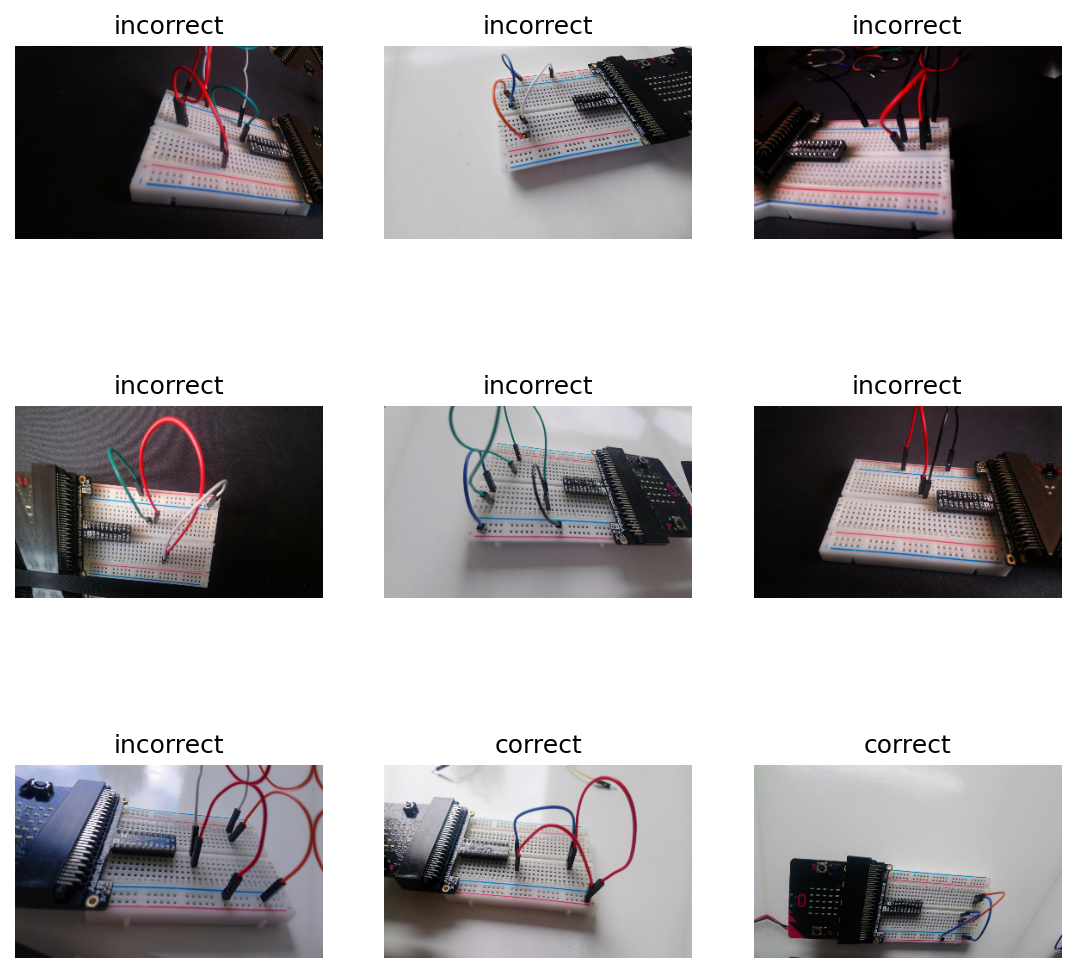

In [6]:
dls = get_loaders(224)
dls.show_batch()

In [7]:
learn = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy, error_rate])

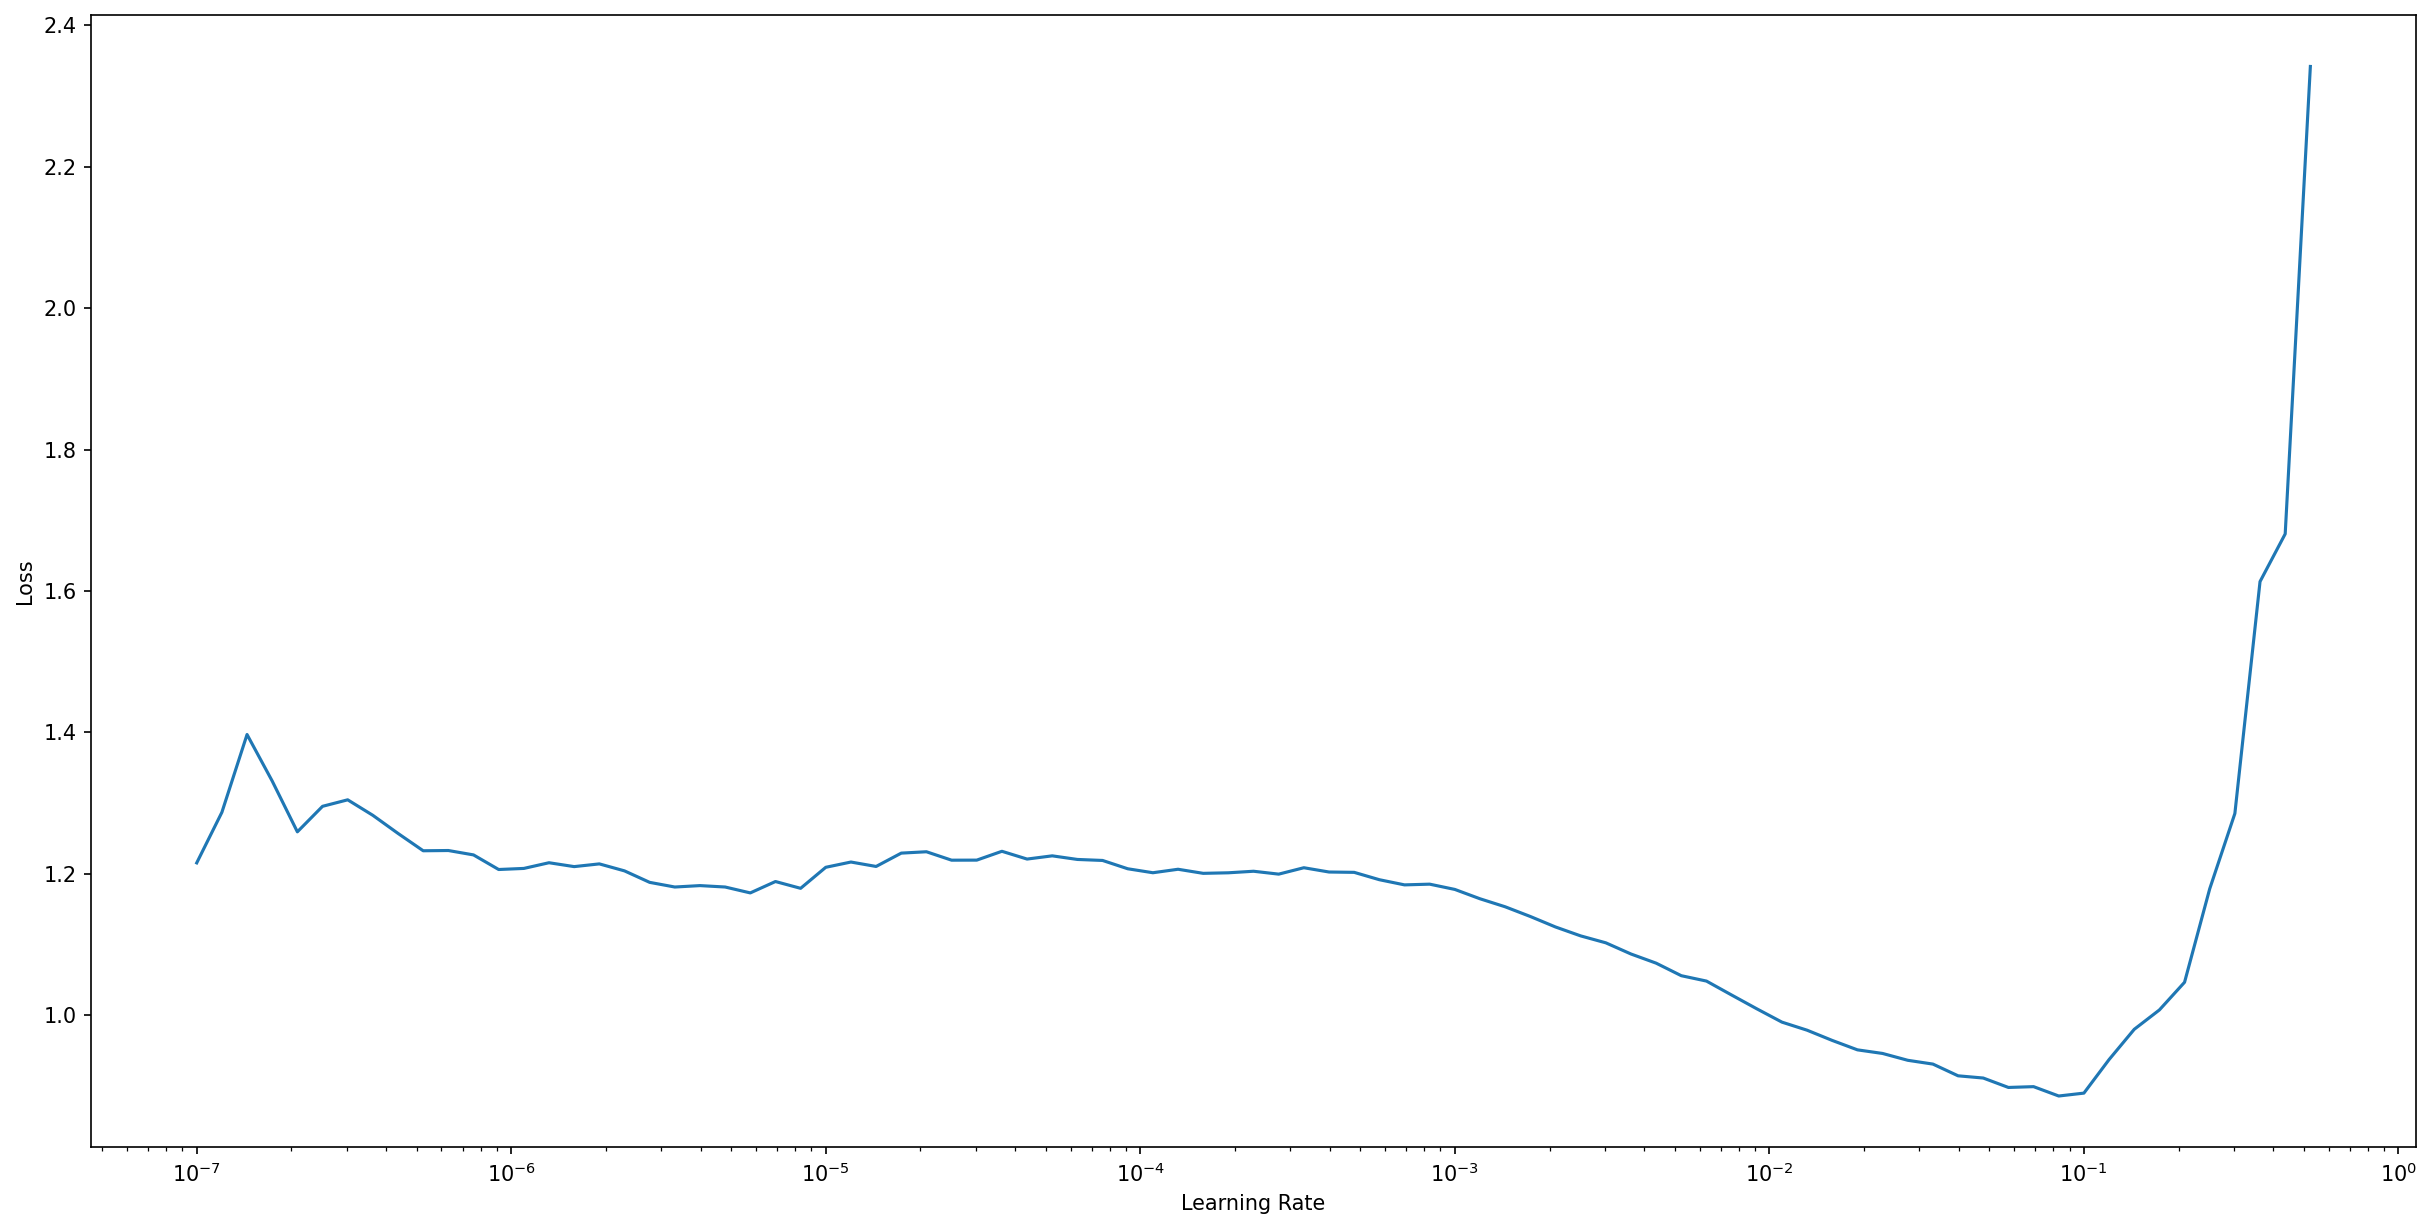

In [8]:
lr_min, _ = learn.lr_find()

In [9]:
learn.save('res34-224-pre') # 0.460, 0.396, 0.8548 / 0.1451

Path('models/res34-224-pre.pth')

In [10]:
learn.fine_tune(15, base_lr = lr_min)

In [11]:
learn.save('res34-224-cold')

Path('models/res34-224-cold.pth')

SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=2.2908675418875646e-06)

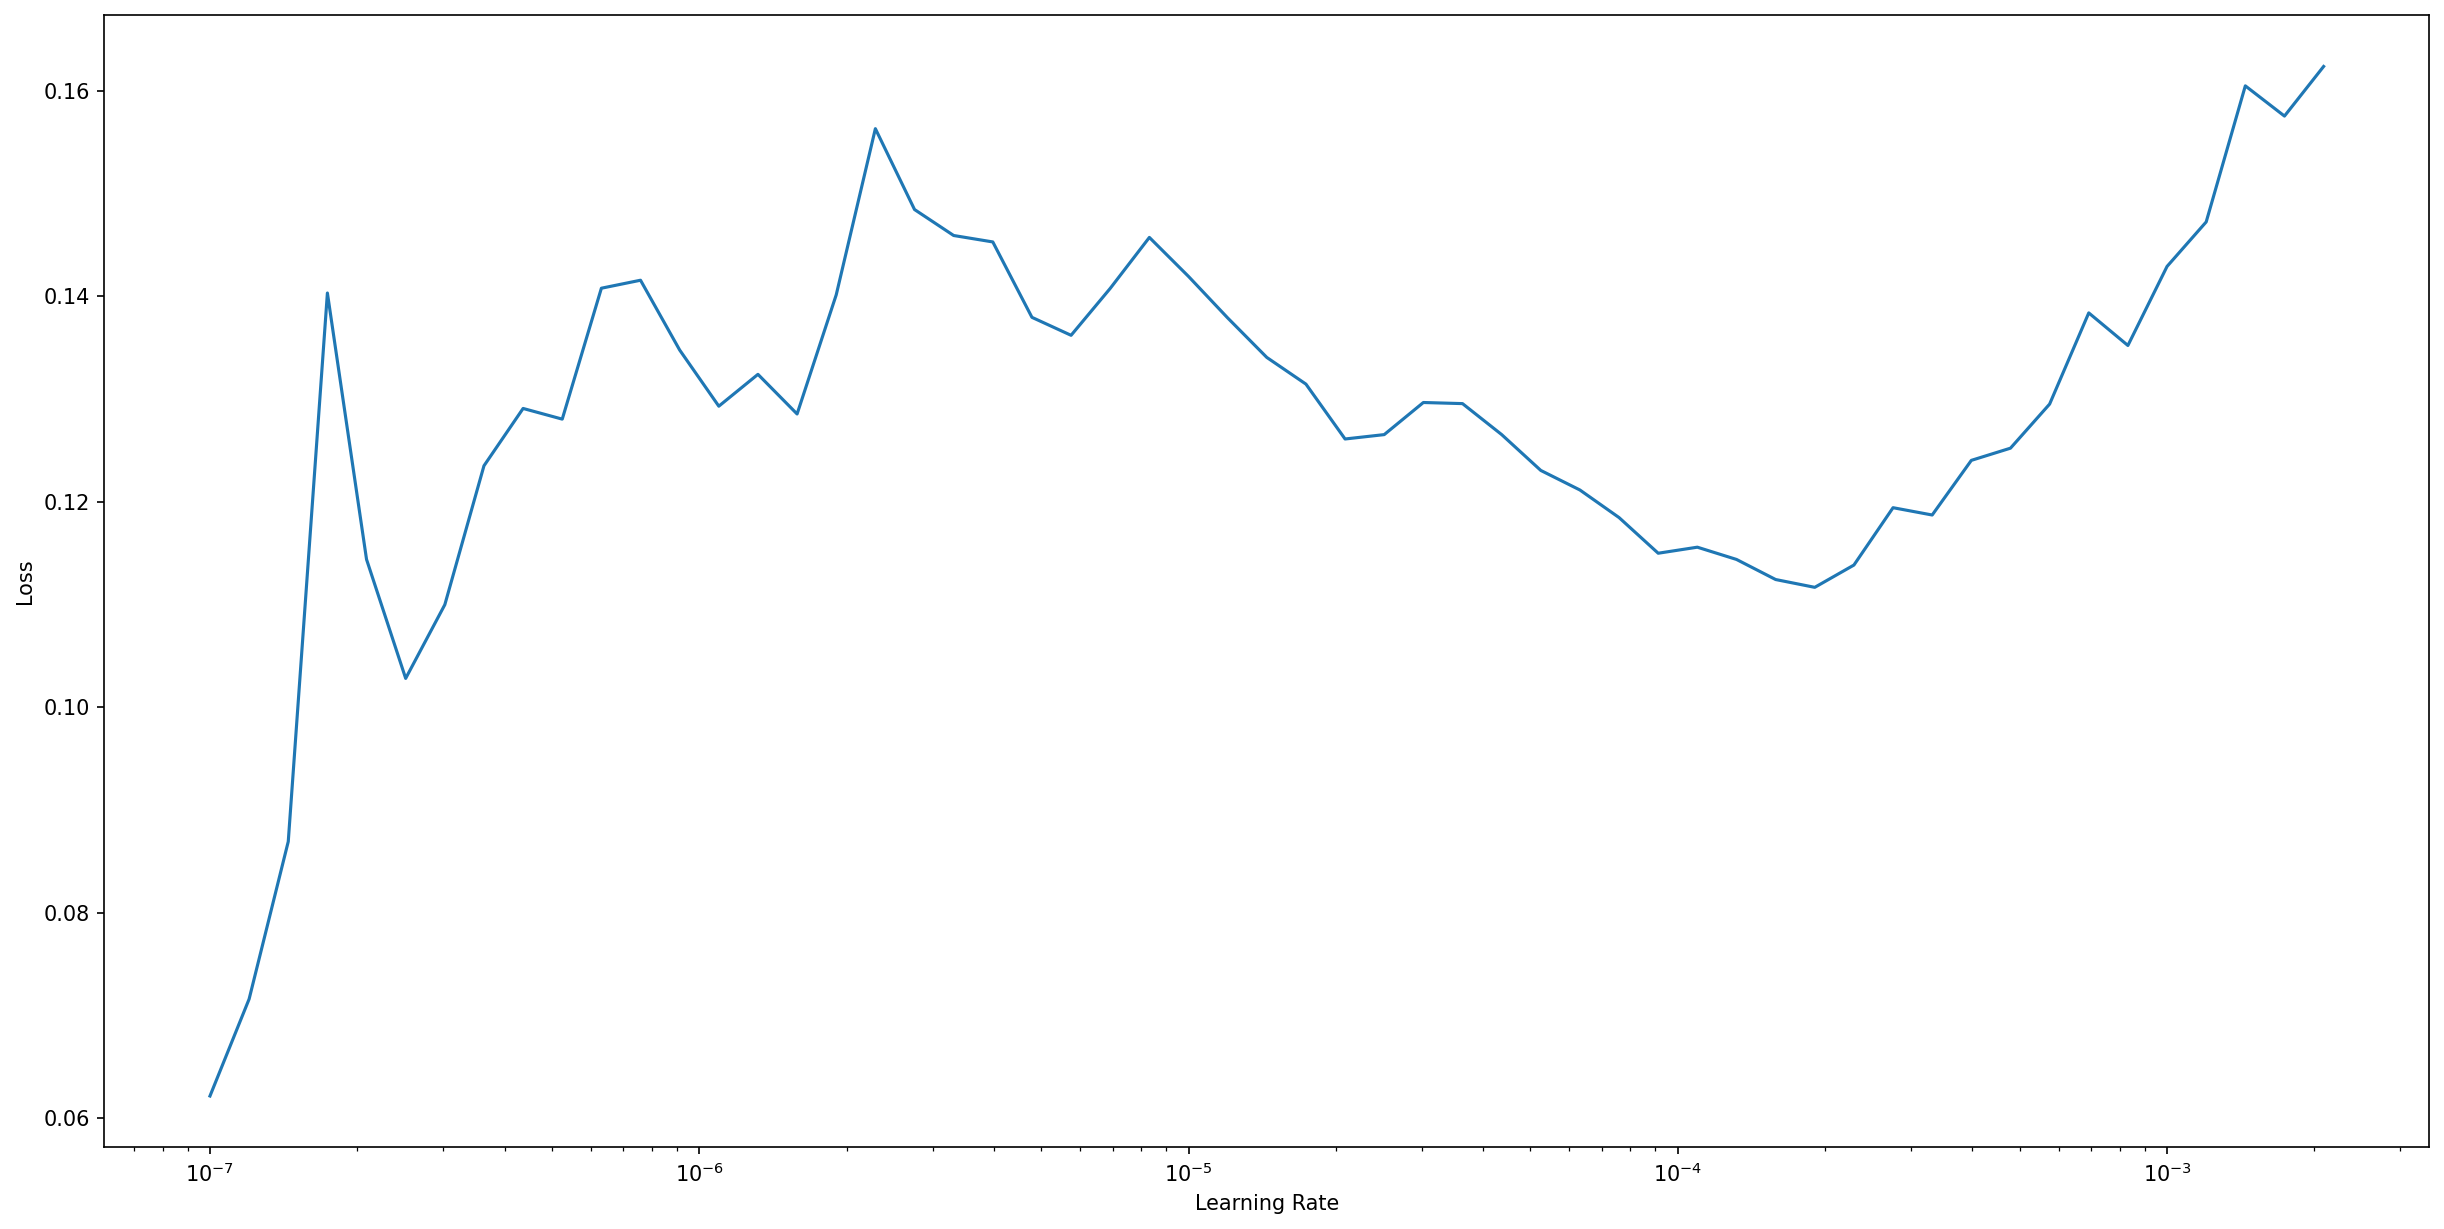

In [12]:
learn.unfreeze()
learn.lr_find()

In [13]:
new_lr = slice(2e-6,1e-3)

learn.fit_one_cycle(15, new_lr)

In [14]:
learn.save('res34-224-hot')

Path('models/res34-224-hot.pth')

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

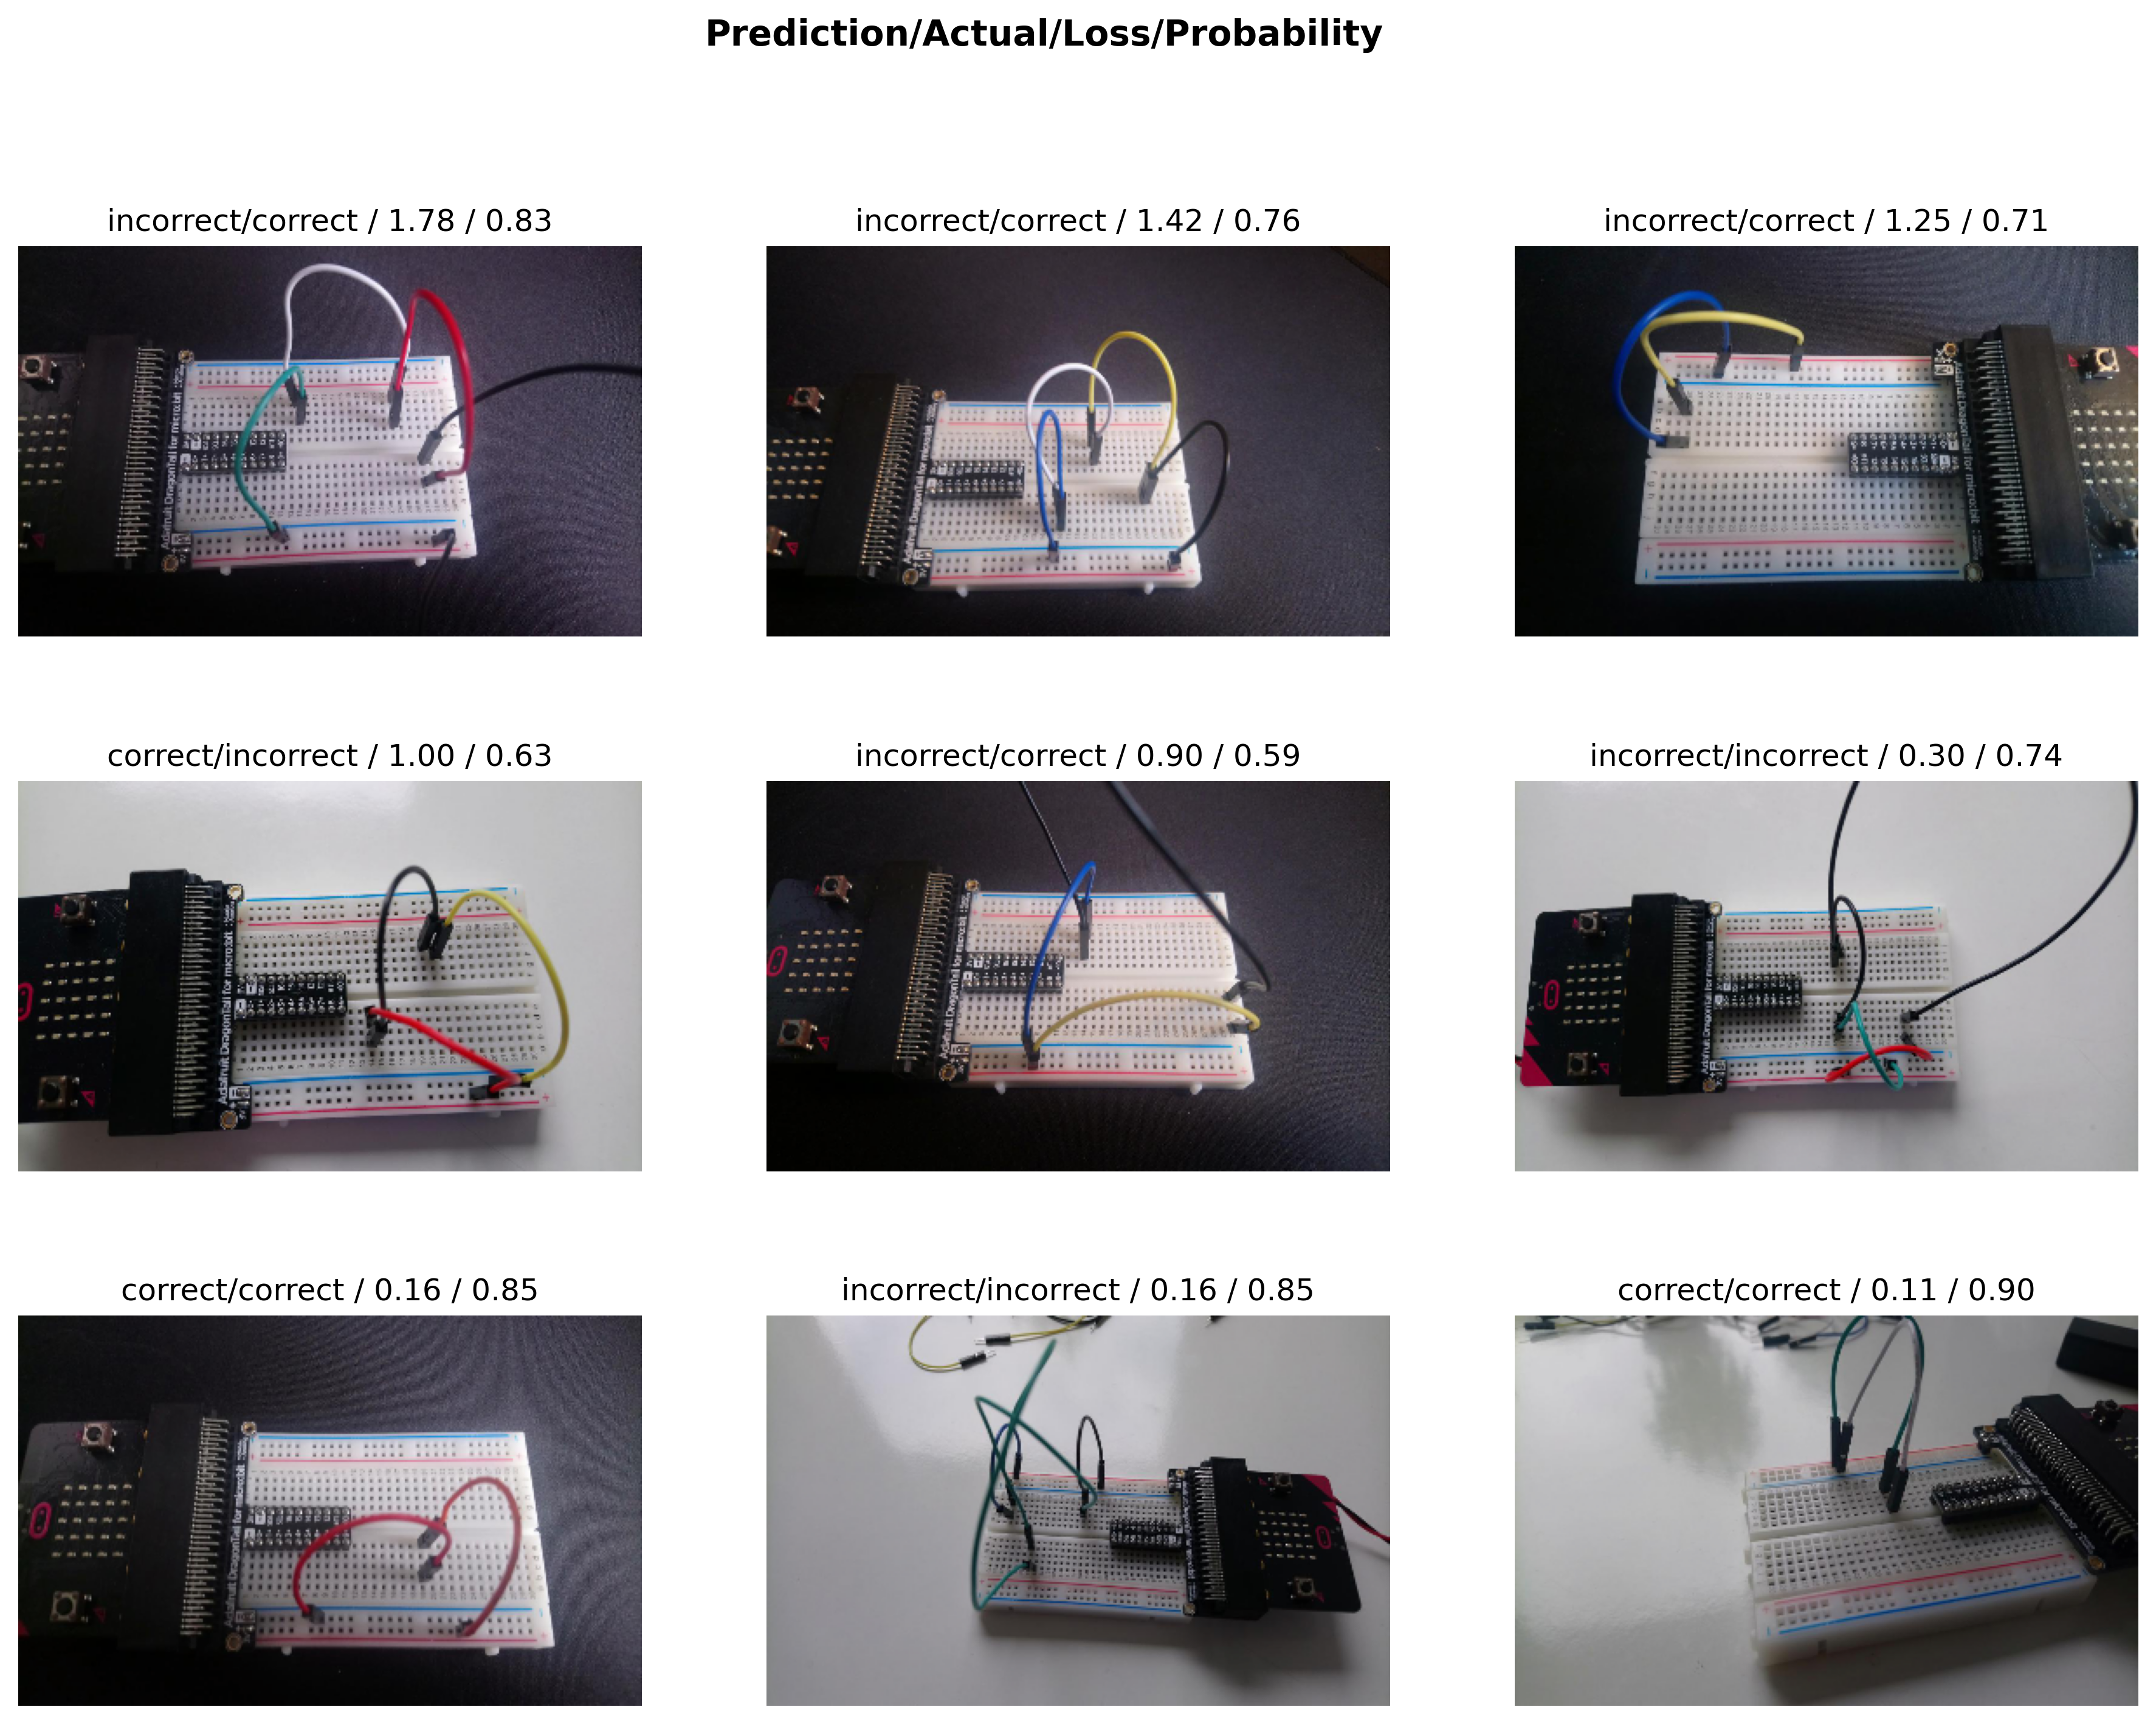

In [16]:
plt.rcParams['figure.dpi'] = 300
interp.plot_top_losses(9, figsize=(15,11))

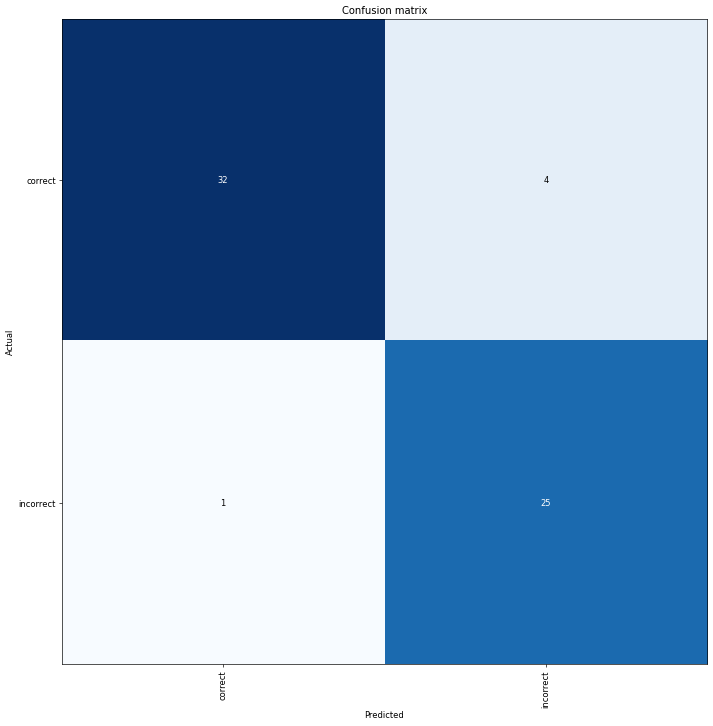

In [17]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Transfer learning
There is no obvious group of pictures the learner performs poorly on, so increase imagesize.

In [6]:
dls = get_loaders(420, bs = 32) # half batchsize for image size increase

learn = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy, error_rate])

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=3.981071586167673e-06)

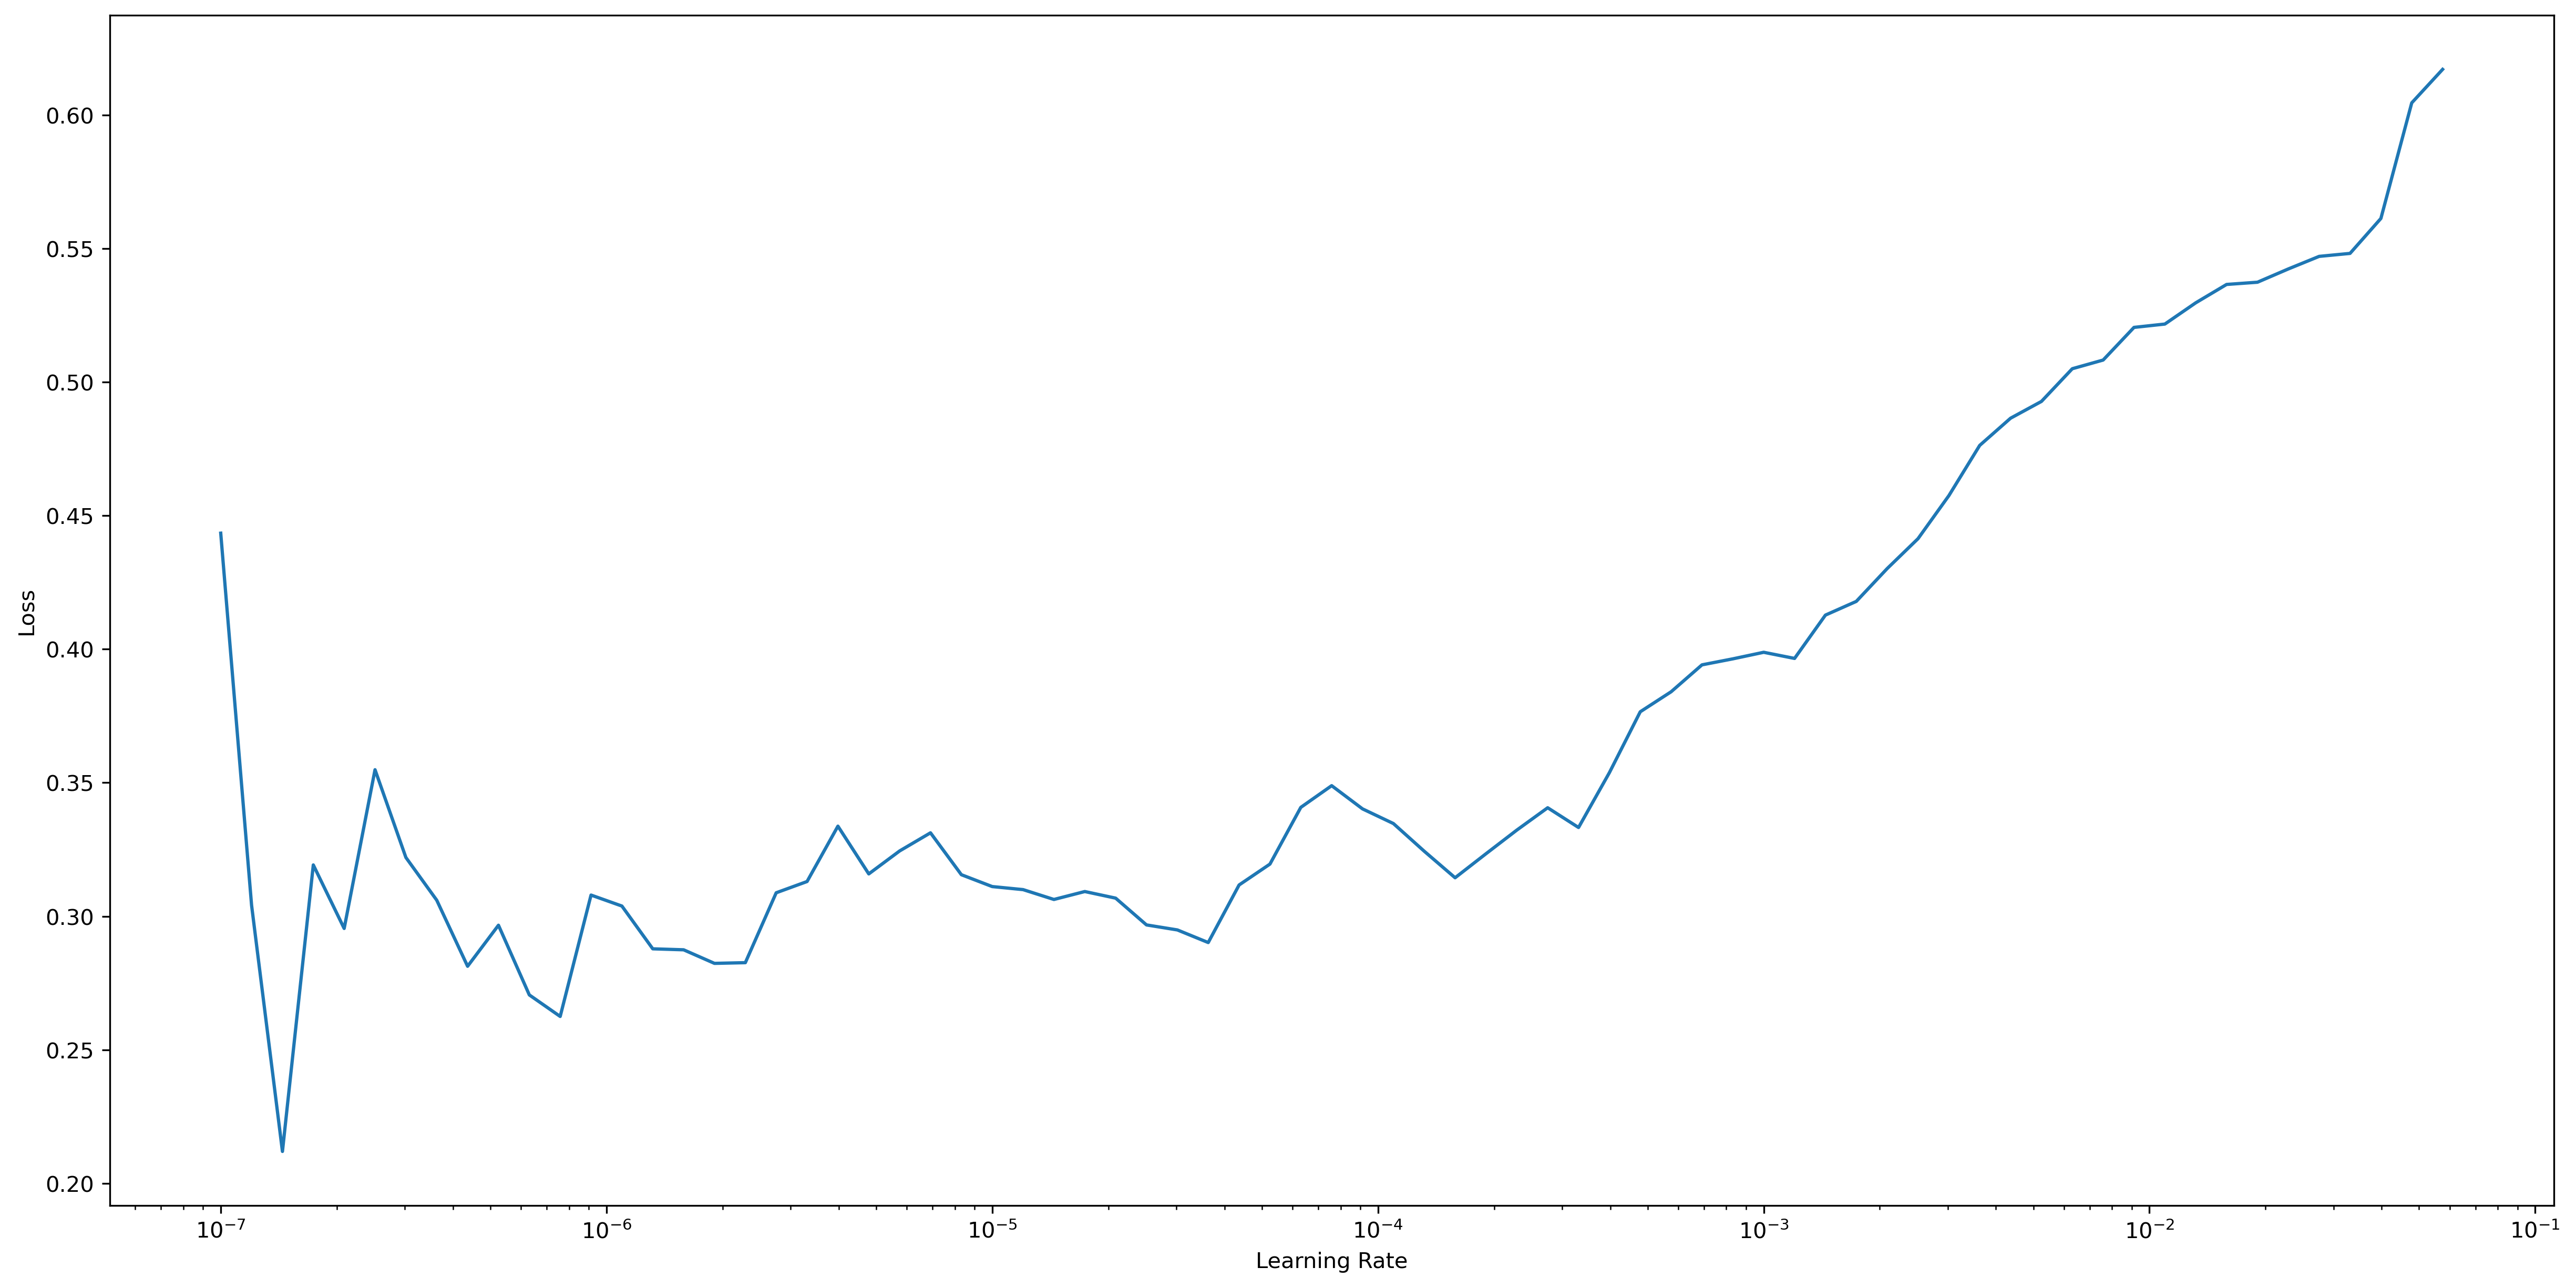

In [19]:
learn.lr_find()

In [21]:
#learn.load('res34-224-hot')

In [22]:
learn.fine_tune(15, 2e-4)

In [23]:
learn.save('res34-420-cold')

Path('models/res34-420-cold.pth')

In [7]:
#learn.load('res34-420-cold')

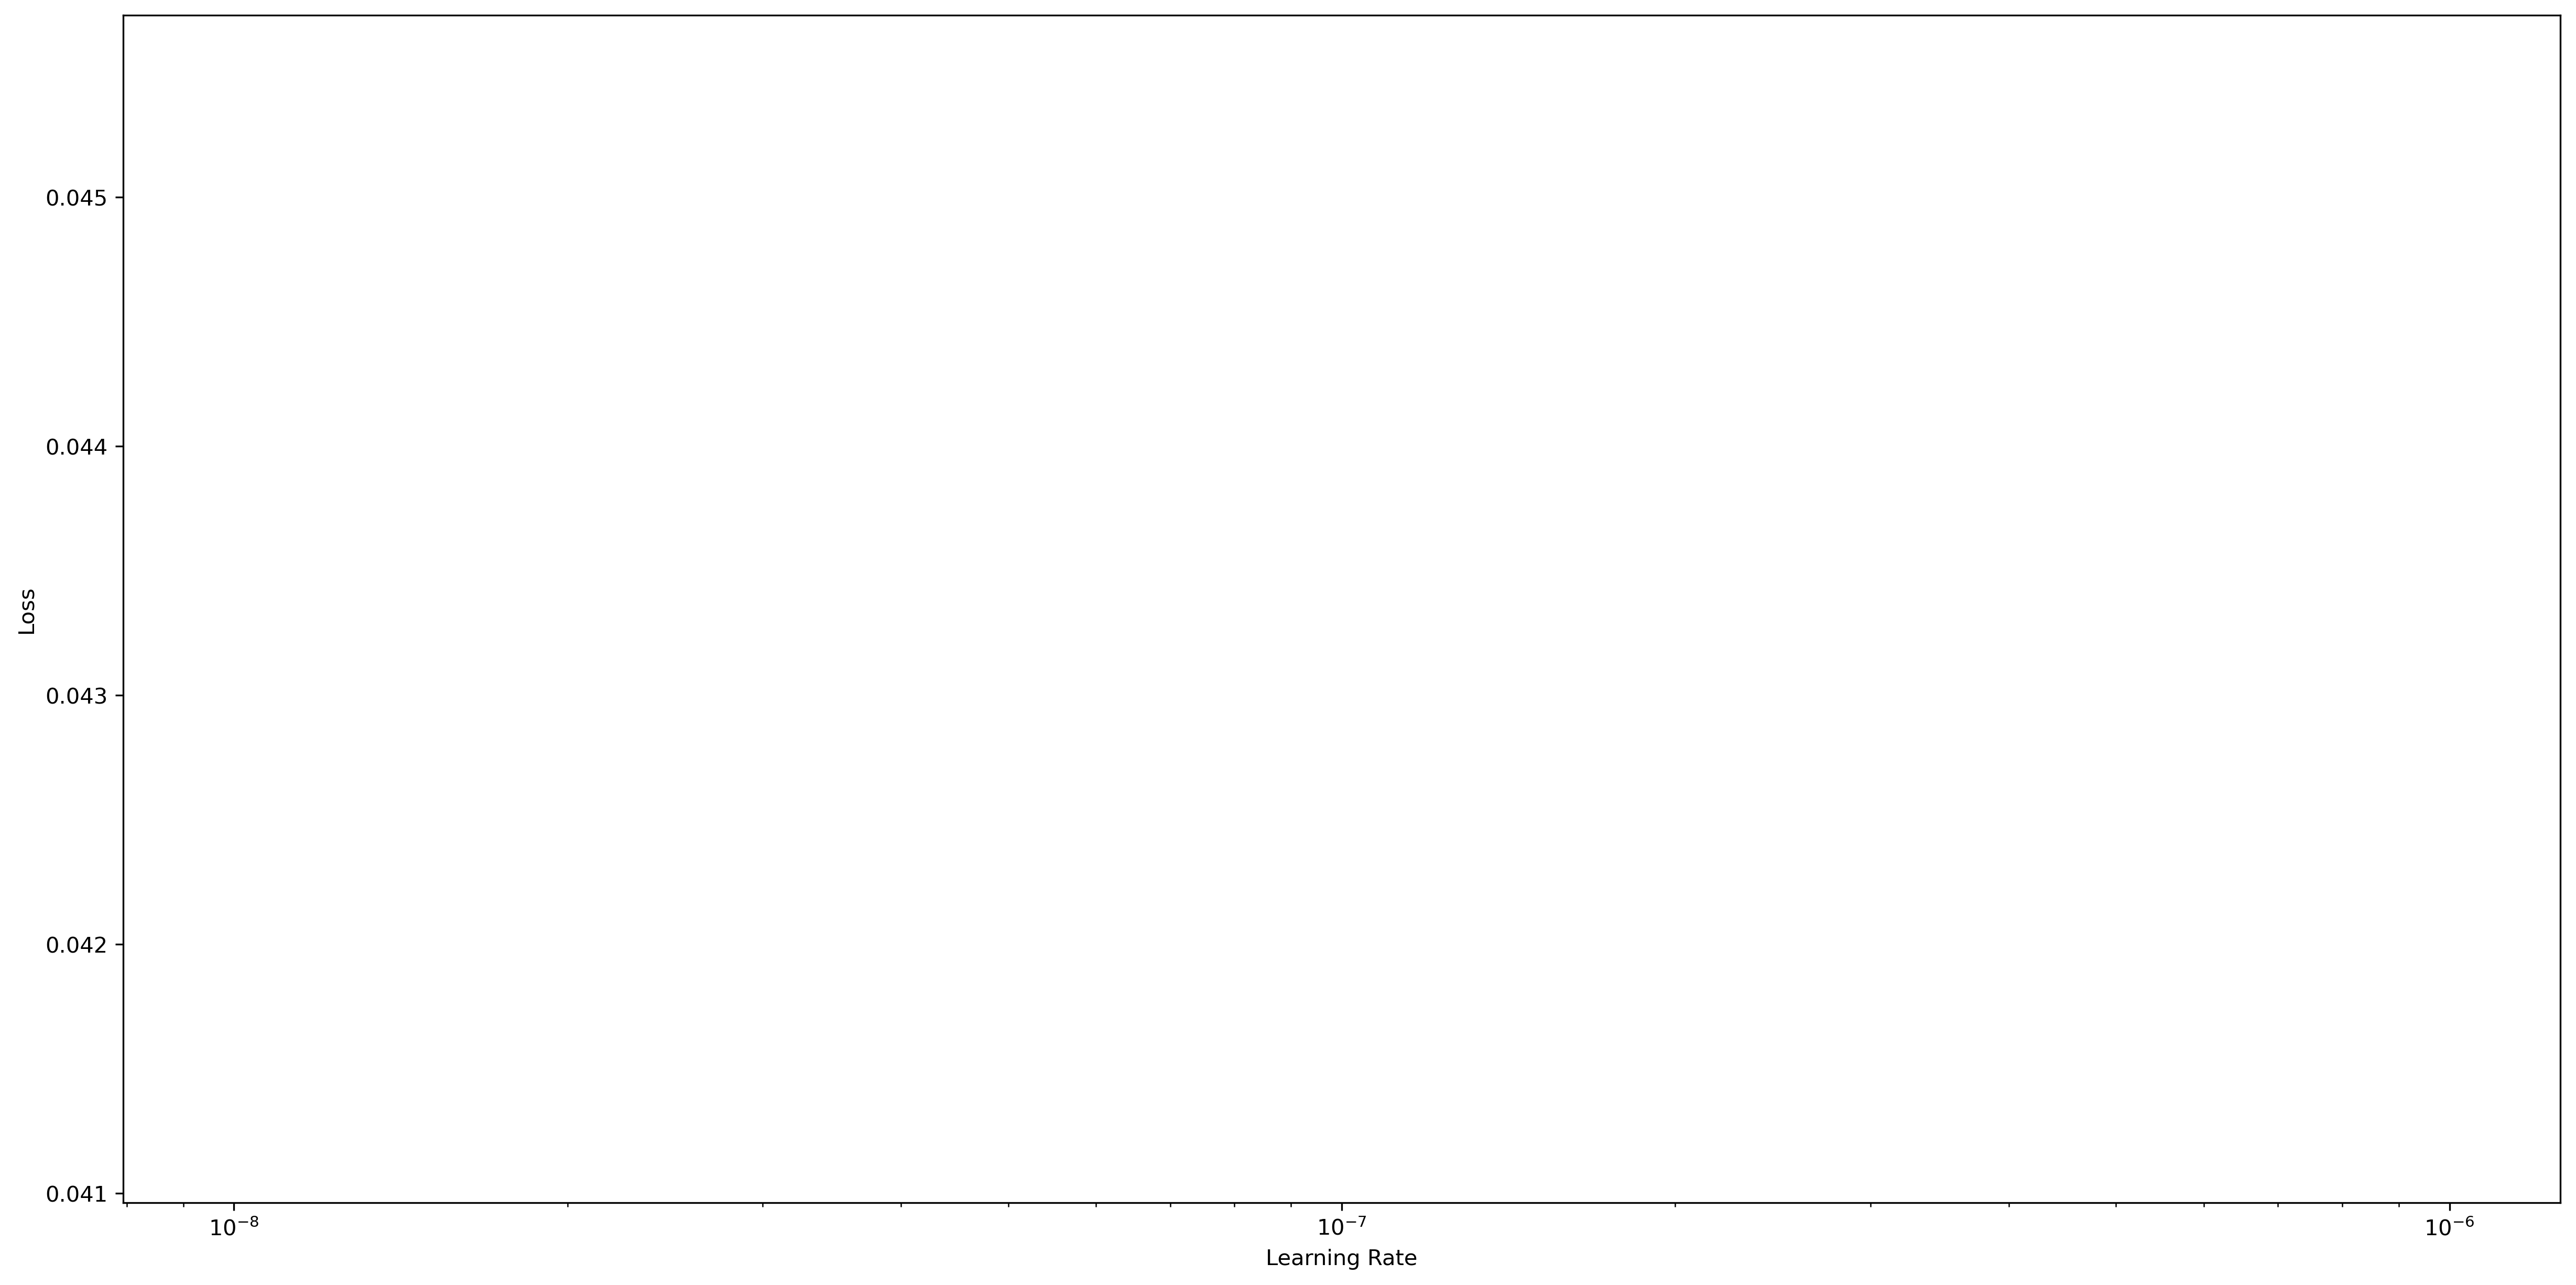

In [24]:
learn.lr_find()

In [8]:
learn.fit_one_cycle(15, slice(1e-4/200,1e-4/2))

In [9]:
learn.save('res34-420-hot')

Path('models/res34-420-hot.pth')

In [6]:
dls = get_loaders(640, bs = 8)

learn = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy, error_rate])

In [8]:
learn.load('res34-420-hot')

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=2.75422871709452e-06)

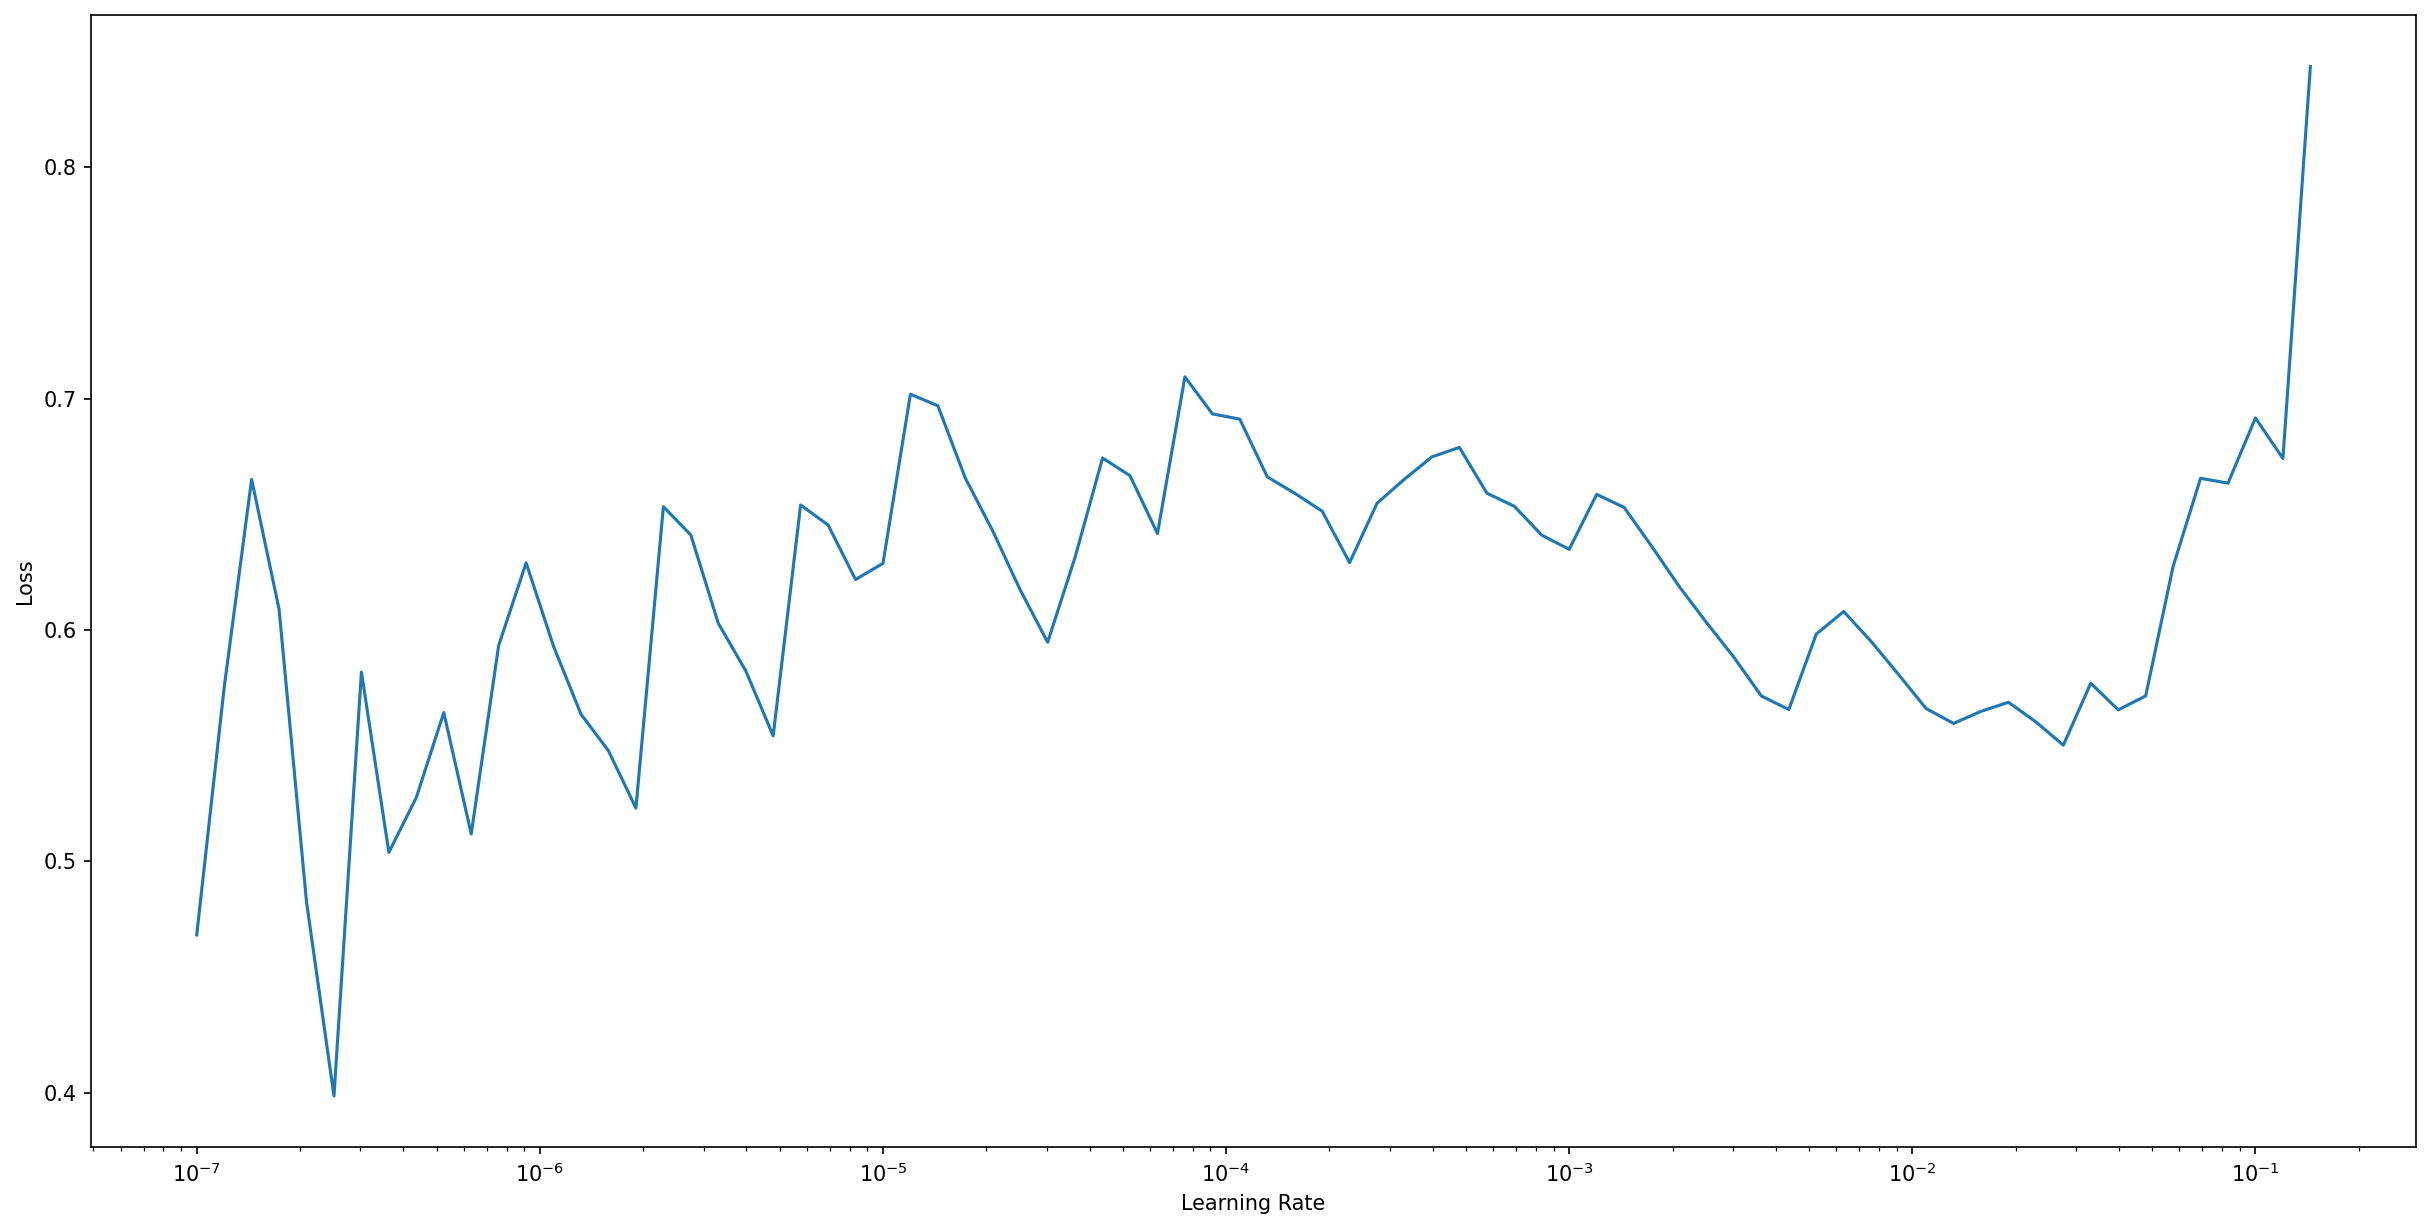

In [9]:
learn.freeze()
learn.lr_find()

In [11]:
learn.save('res34-640-pre')

Path('models/res34-640-pre.pth')

In [12]:
learn.fine_tune(15, 1e-3)

In [13]:
learn.save('res34-640-cold')

Path('models/res34-640-cold.pth')

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=6.309573450380412e-07)

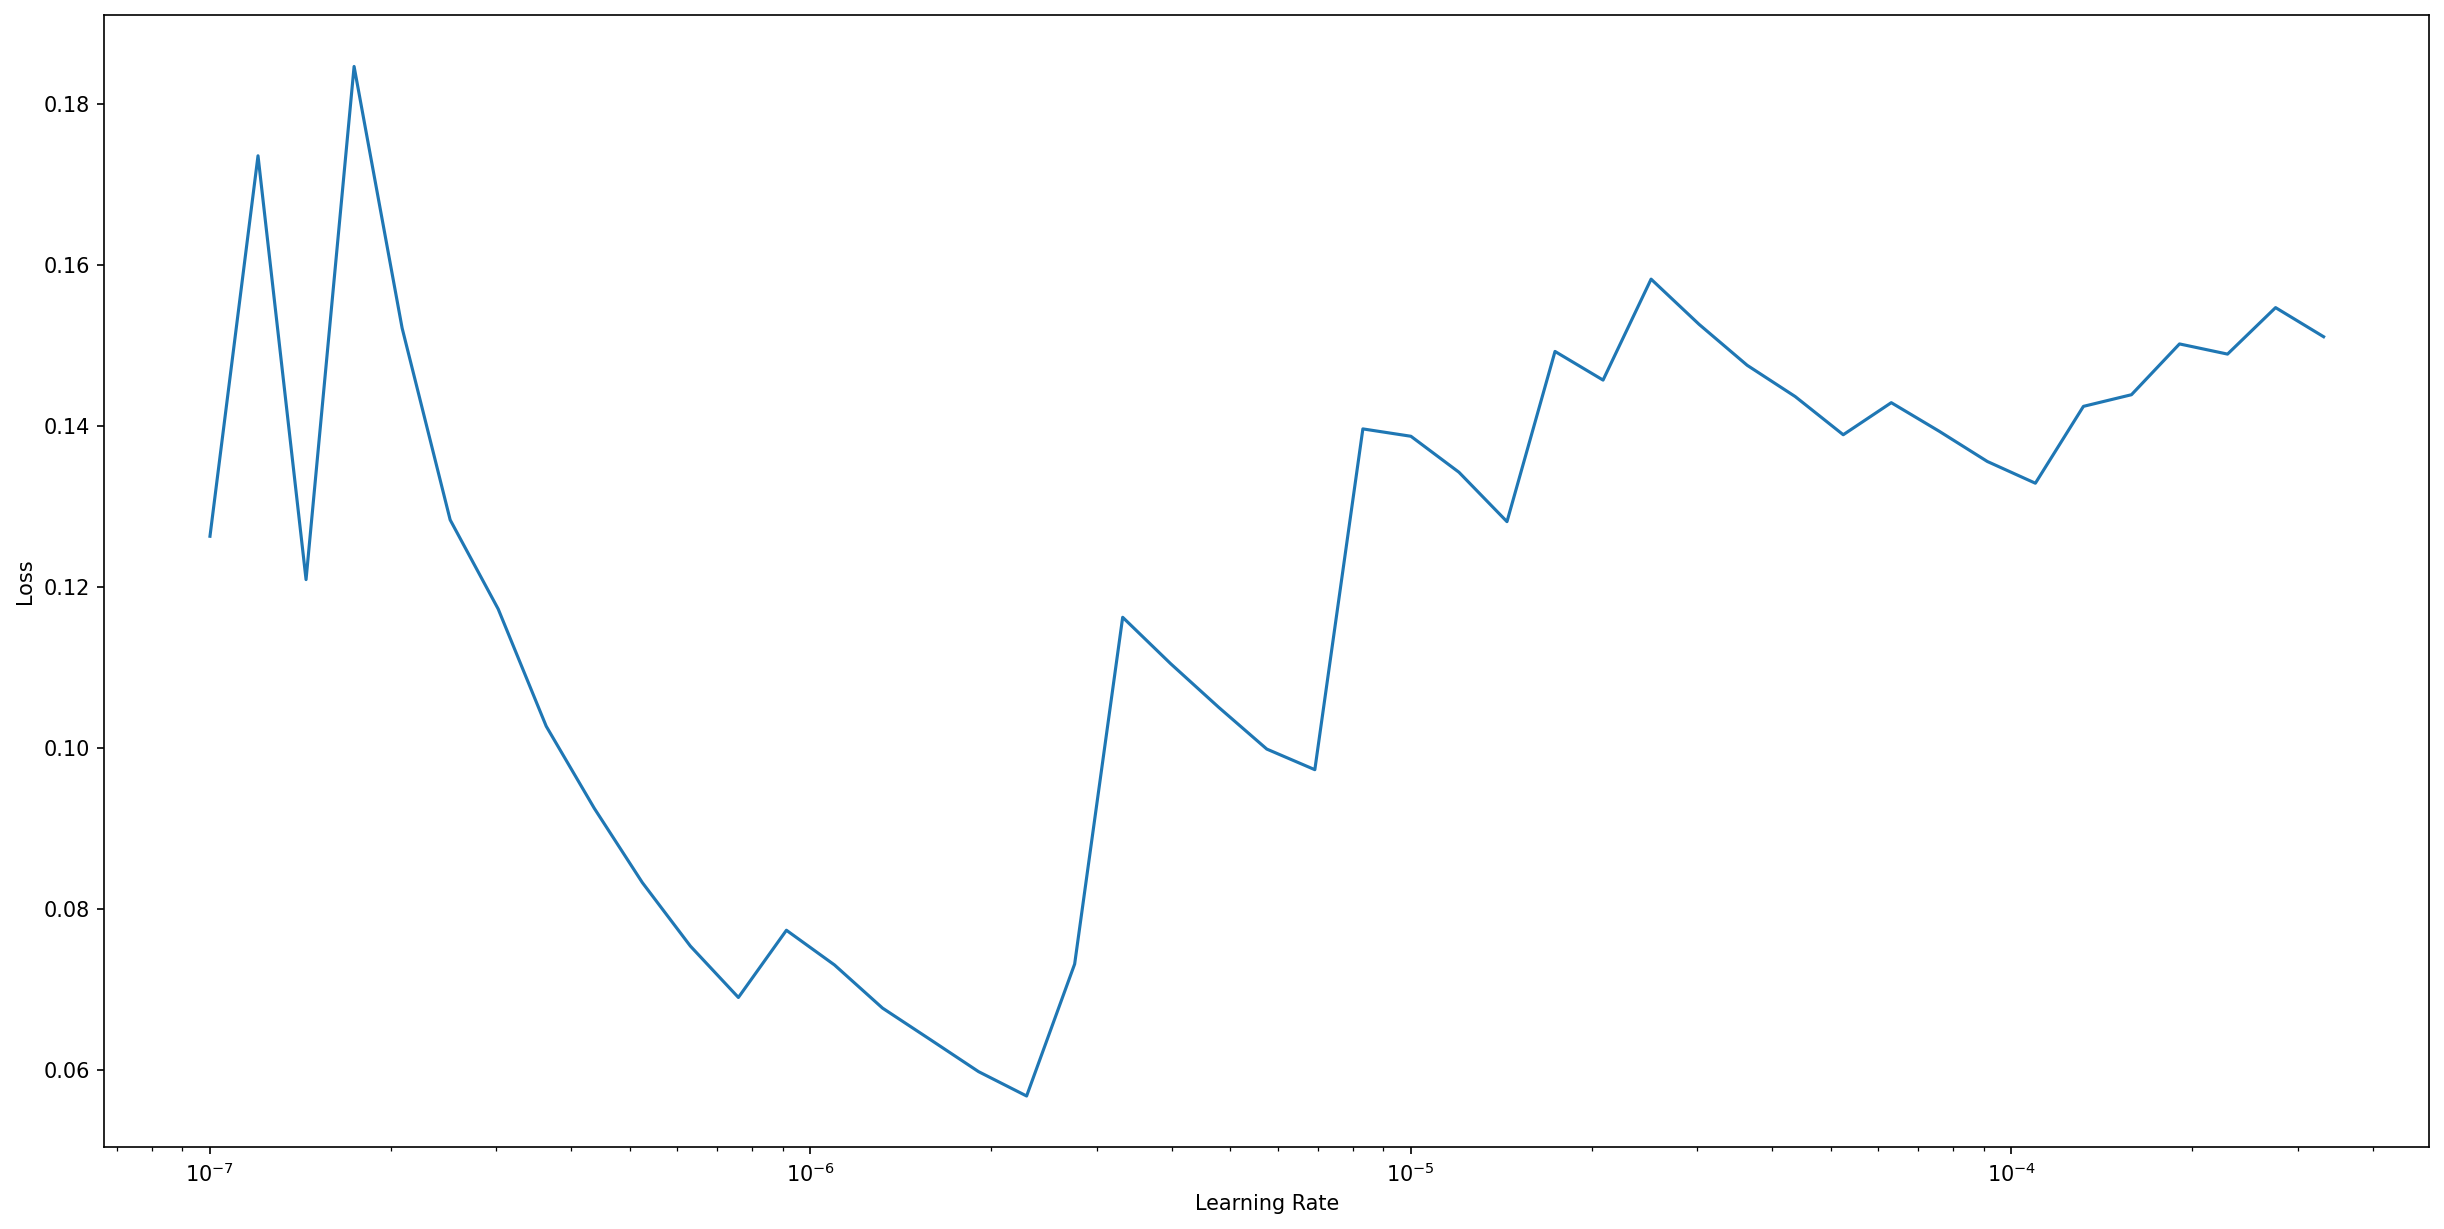

In [14]:
learn.unfreeze()
learn.lr_find()

In [15]:
learn.fit_one_cycle(20, slice(1e-7,2e-6))

In [16]:
learn.save('res34-640-hot')

Path('models/res34-640-hot.pth')